In [9]:
import os
import pickle

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from metrics.visualization import visualization

%matplotlib inline

## PCA and t-SNE visualization

In [10]:
path = "output/test"

with open(f"{path}/train_data.pickle", "rb") as fb:
    ori_data = pickle.load(fb)
    #ori_data = ori_data.reshape(ori_data.shape[0]*ori_data.shape[1], ori_data.shape[2])
with open(f"{path}/fake_data.pickle", "rb") as fb:
    new_data = pickle.load(fb)
    #new_data = new_data.reshape(new_data.shape[0]*new_data.shape[1], new_data.shape[2])

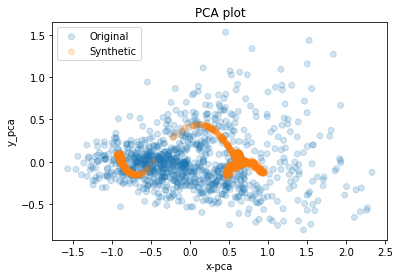

In [11]:
visualization(ori_data, new_data, 'pca')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.003s...
[t-SNE] Computed neighbors for 2000 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.038078
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.334538
[t-SNE] KL divergence after 300 iterations: 0.770206


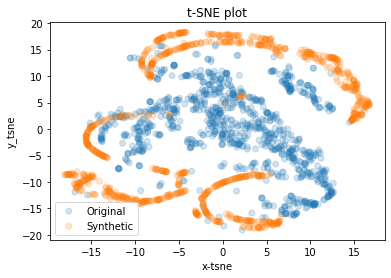

In [12]:
visualization(ori_data, new_data, 'tsne')

In [21]:
import pandas as pd

In [23]:
data = pd.read_csv("data/BG_data/V_CGMS_2.csv")

In [24]:
data

,151
0,155
1,156
2,156
3,153
4,148
...,...
858,191
859,181
860,172
861,163


In [32]:
# Local packages
import os
from typing import Union, Tuple, List
import warnings
warnings.filterwarnings("ignore")

# 3rd party modules
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def data_preprocess(
    file_name: str, 
    max_seq_len: int, 
    num_patients : int=17,  
    padding_value: float=-1.0,
    impute_method: str="mode", 
    scaling_method: str="minmax",  
) -> Tuple[np.ndarray, np.ndarray, List]:
    """Load the data and preprocess into 3d numpy array.
    Preprocessing includes:
    1. Remove outliers
    2. Extract sequence length for each patient id
    3. Impute missing data 
    4. Normalize data
    6. Sort dataset according to sequence length

    Args:
    - file_name (str): CSV file name
    - max_seq_len (int): maximum sequence length
    - impute_method (str): The imputation method ("median" or "mode") 
    - scaling_method (str): The scaler method ("standard" or "minmax")

    Returns:
    - processed_data: preprocessed data
    - time: ndarray of ints indicating the length for each data
    - params: the parameters to rescale the data 
    """

    #########################
    # Load data
    #########################

    index = 'Idx'

    # Load csv
    print("Loading data...\n")
    if file_name=="stock":
        ori_data = pd.read_csv('./data/stock.csv')
        
    else: 
        ori_data = bg_level('./data', max_seq_len, num_patients)
        #dim = 1
    # Remove spurious column, so that column 0 is now 'admissionid'.
    #if ori_data.columns[0] == "Unnamed: 0":  
    #    ori_data = ori_data.drop(["Unnamed: 0"], axis=1)
    #    ori_data.to_csv("./dropped.csv")
        
    #########################
    # Remove outliers from dataset
    #########################
    no = ori_data.shape[0]
    #z_scores = stats.zscore(ori_data, axis=0, nan_policy='omit')
    #z_filter = np.nanmax(np.abs(z_scores), axis=1) < 3
    #ori_data = ori_data[z_filter]
    #print(f"Dropped {no - ori_data.shape[0]} rows (outliers)\n")

    # Parameters
    if file_name=="stock":
        uniq_id = np.unique(ori_data[index])
        no = len(uniq_id)
        dim = len(ori_data.columns) - 1
    elif file_name=="bg_level":
        #uniq_id = np.unique(ori_data[index])
        no = ori_data.shape[0]
        dim = 1

    #########################
    # Impute, scale and pad data
    #########################
    
    # Initialize scaler
    if scaling_method == "minmax":
        scaler = MinMaxScaler()
        scaler.fit(ori_data)
        params = [scaler.data_min_, scaler.data_max_]
    
    elif scaling_method == "standard":
        scaler = StandardScaler()
        scaler.fit(ori_data)
        params = [scaler.mean_, scaler.var_]

    # Imputation values
    if impute_method == "median":
        impute_vals = ori_data.median()
    elif impute_method == "mode":
        impute_vals = stats.mode(ori_data).mode[0]
    else:
        raise ValueError("Imputation method should be `median` or `mode`")    

    # TODO: Sanity check for padding value
    # if np.any(ori_data == padding_value):
    #     print(f"Padding value `{padding_value}` found in data")
    #     padding_value = np.nanmin(ori_data.to_numpy()) - 1
    #     print(f"Changed padding value to: {padding_value}\n")
    print(ori_data.shape)
    # Output initialization
    output = np.empty([no, max_seq_len, dim])  # Shape:[no, max_seq_len, dim]
    output.fill(padding_value)
    print("output", output.shape)
    time = []

    if file_name == "bg_level":
        scaled_data = scaler.transform(ori_data)
        # For each uniq id
        for i in tqdm(range(no)):
            # Extract the time-series data with a certain admissionid
            curr_data = scaled_data[i, :]
            #print(curr_data.shape)
            curr_data = curr_data.reshape(-1, 1)
            #print(curr_data.shape)
            # Impute missing data
            #curr_data = imputer(curr_data, impute_vals)
            #print(curr_data.shape)
            # Normalize data
            #curr_data = scaler.transform(curr_data)
            
            # Extract time and assign to the preprocessed data (Excluding ID)
            curr_no = len(curr_data)

            # Pad data to `max_seq_len`
            if curr_no >= max_seq_len:
                output[i, :, :] = curr_data[:max_seq_len, :]  # Shape: [1, max_seq_len, dim]
                time.append(max_seq_len)
            else:
                output[i, :curr_no, :] = curr_data[:, :]  # Shape: [1, max_seq_len, dim]
                time.append(curr_no)
        
        # Output initialization
        ori_output = np.empty([no, max_seq_len, dim])  # Shape:[no, max_seq_len, dim]
        ori_output.fill(padding_value)
        #time = []
        # For each uniq id
        for i in tqdm(range(no)):
            # Extract the time-series data with a certain admissionid

            curr_data = ori_data.to_numpy()[i, :]
            curr_data = curr_data.reshape(-1, 1)
            # Impute missing data
            #curr_data = imputer(curr_data, impute_vals)

            # Normalize data
            #curr_data = scaler.transform(curr_data)
            
            # Extract time and assign to the preprocessed data (Excluding ID)
            curr_no = len(curr_data)

            # Pad data to `max_seq_len`
            if curr_no >= max_seq_len:
                ori_output[i, :, :] = curr_data[:max_seq_len, :]  # Shape: [1, max_seq_len, dim]
                #time.append(max_seq_len)
            else:
                ori_output[i, :curr_no, :] = curr_data[:, :]  # Shape: [1, max_seq_len, dim]
                #time.append(curr_no)
        print(output.shape)
    
    

    return ori_output, output, time, params, max_seq_len, padding_value, scaler

  
def bg_level(data_path, seq_len, num_patients):
    data = []
    for i in range(num_patients):
        p_data = np.loadtxt(data_path + '/BG_data/V_CGMS_{}.csv'.format(i+1), delimiter=",")
        #print(p_data)
        #temp_data = []
        # cut data by sequence length
        for j in range(0, len(p_data) - seq_len):
            #x = [i]
            #print(x)
            #print(p_data[j:j + seq_len].tolist())
            #x = np.array(x + p_data[j:j + seq_len].tolist())
            #print(x)
            data.append(p_data[j:j + seq_len])
    #print(train_data)
    # Mix the datasets (to make it similar to i.i.d)
    #idx = np.random.permutation(len(train_data))    
    #data = []
    #for i in range(len(train_data)):
    #    data.append(train_data[idx[i]])
    data = np.array(data)
    #data = data.reshape((data.shape[0], data.shape[1], 1))
    data = pd.DataFrame(data)
    #data.rename(columns={0:'Idx'}, inplace=True)
    print(data.shape)
    #data.to_csv("./data/bg.csv")
    return data
    

In [33]:
ori_output, output, time, params, max_seq_len, padding_value, scaler = data_preprocess(
    "bg_level", 
    48, 
    17,  
    padding_value=-1.0,
    impute_method="mode", 
    scaling_method="minmax",  
) 

100%|██████████| 13872/13872 [00:00<00:00, 189451.46it/s]

Loading data...

(13872, 48)
(13872, 48)
output (13872, 48, 1)
(13872, 48, 1)


In [34]:
ori_output

array([[[118.],
        [117.],
        [116.],
        ...,
        [110.],
        [111.],
        [112.]],

       [[117.],
        [116.],
        [113.],
        ...,
        [111.],
        [112.],
        [113.]],

       [[116.],
        [113.],
        [110.],
        ...,
        [112.],
        [113.],
        [115.]],

       ...,

       [[ 94.],
        [ 96.],
        [ 97.],
        ...,
        [128.],
        [129.],
        [130.]],

       [[ 96.],
        [ 97.],
        [ 98.],
        ...,
        [129.],
        [130.],
        [131.]],

       [[ 97.],
        [ 98.],
        [ 99.],
        ...,
        [130.],
        [131.],
        [133.]]])

In [35]:
import matplotlib.pyplot as plt

(48,)


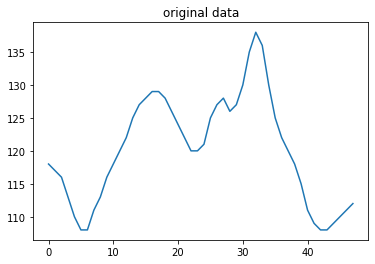

(48,)


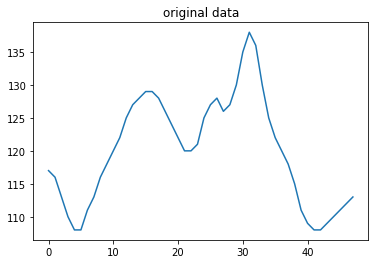

(48,)


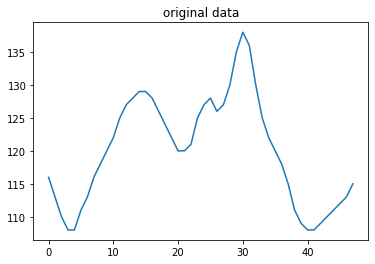

(48,)


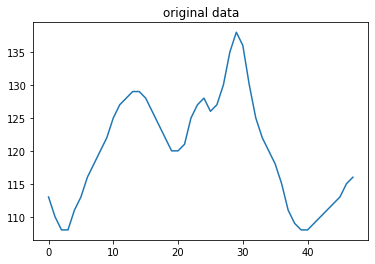

(48,)


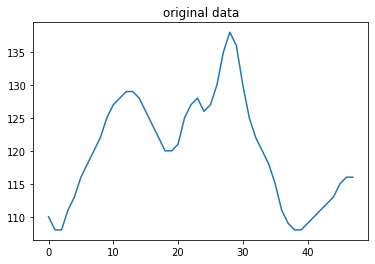

(48,)


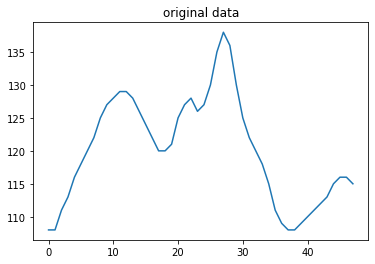

(48,)


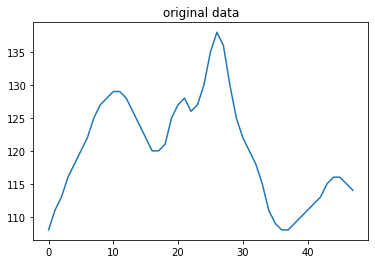

(48,)


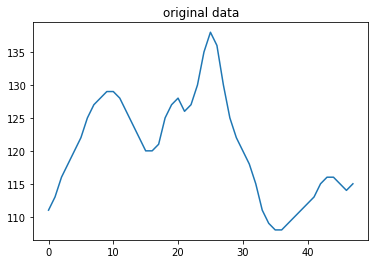

(48,)


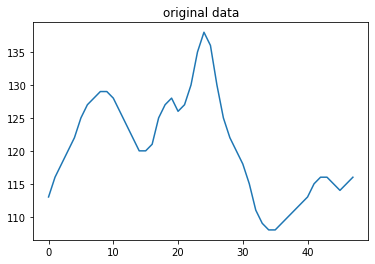

(48,)


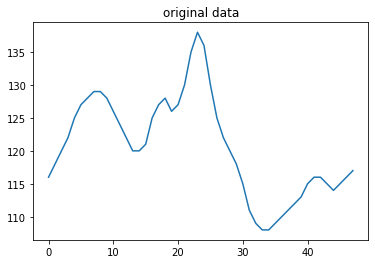

(48,)


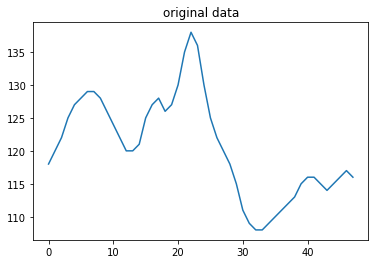

(48,)


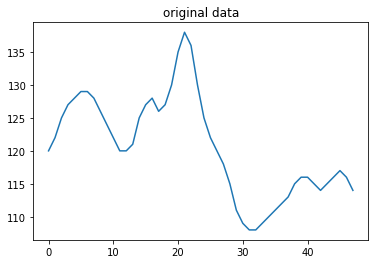

(48,)


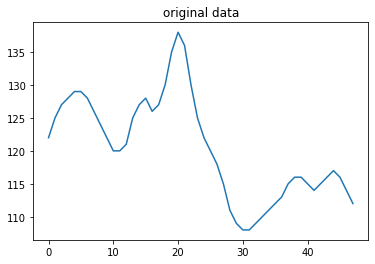

(48,)


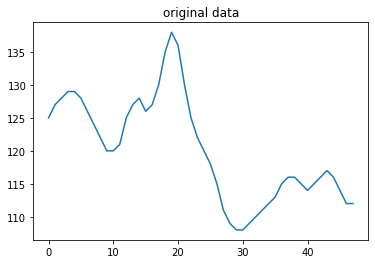

(48,)


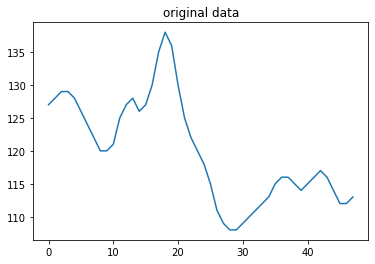

(48,)


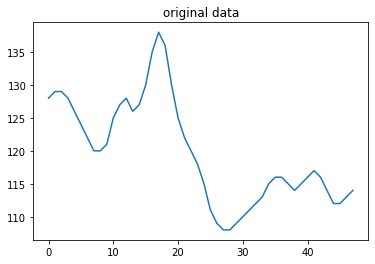

(48,)


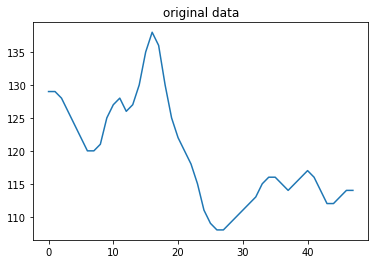

(48,)


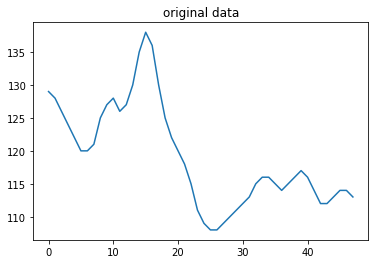

(48,)


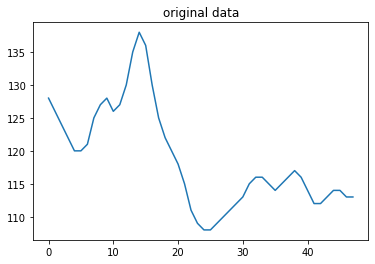

(48,)


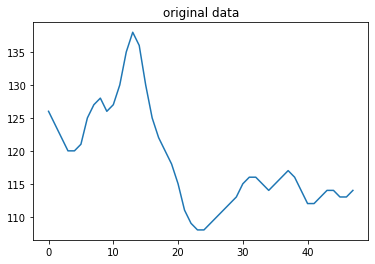

<Figure size 432x288 with 0 Axes>

In [36]:
for i in range(20):
    for j in range(ori_output.shape[-1]):
        graph_data = ori_output[i, :, j]
        print(graph_data.shape)
        plt.title('original data')
        plt.plot(graph_data)
    plt.show()   
    plt.clf() 